In [1]:
# define the ILC model
import tensorflow as tf


def compute_cof(x,y):
    x = tf.keras.layers.Flatten()(x)
    y = tf.keras.layers.Flatten()(y)
    fz = tf.reduce_sum(x*y, axis=-1)
    fm = tf.norm(x, axis=-1)*tf.norm(y, axis=-1)
    return fz/fm

def Conv_1D_Block(x, kernel_num, kernel_size, strides):
    x = tf.keras.layers.Conv1D(kernel_num, kernel_size, strides=strides, padding="same")(x) #kernel_initializer="he_normal")(x)
    x = tf.keras.layers.Activation('swish')(x)
    return x
  
def cof_layer(fms):
    cof_list = []
    for i in range(len(fms)-1):
        #cof_sample = []
        for j in range(i+1,len(fms)):
            cof = compute_cof(fms[i], fms[j])
            cof = tf.expand_dims(cof, axis=-1)
            cof_list.append(cof)
    return cof_list

def stem(inputs, num_filters, filter_len):
    conv = Conv_1D_Block(inputs, num_filters, filter_len, 2)
    if conv.shape[1] <= 2:
        pool = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="same")(conv)
    else:
        pool = tf.keras.layers.MaxPooling1D(pool_size=3, strides=2, padding="same")(conv)

    return pool

def conv_block(x, num_filters, bottleneck=True):
    if bottleneck:
        num_filters_bottleneck = num_filters * 4
        x = Conv_1D_Block(x, num_filters_bottleneck, 1, 1)

    out = Conv_1D_Block(x, num_filters, 7, 1)
    return out


def dense_block(x, num_filters, num_layers, bottleneck=True):
    cb_list = []
    for i in range(num_layers):
        cb = conv_block(x, num_filters, bottleneck=bottleneck)
        cb_list.append(cb)
        x = tf.keras.layers.concatenate([x, cb], axis=-1)
    return x, cb_list


 
# denseblock share

def branch_model(inputs_shape):
    inputs = tf.keras.Input(inputs_shape)
    stem_block = stem(inputs, num_filters=16, filter_len=11)
    dense_op, conv_op_list = dense_block(stem_block, num_filters = 8, num_layers = 3, bottleneck=True)
    conv_op_list.append(stem_block)#在倒数第二个
    conv_op_list.append(dense_op)#在最后
    model = tf.keras.Model(inputs, conv_op_list)
    return model


def build_model(input_shape, output_dims):
    inputs = tf.keras.Input(input_shape)
    input_list = tf.unstack(inputs, axis=-1)
    input_list_exp = [tf.expand_dims(i, -1) for i in input_list]
    stem_ops = []
    conv1_ops = []
    conv2_ops = []
    conv3_ops = []
    dense_ops = []
    branch = branch_model((input_list_exp[0].shape[1], input_list_exp[0].shape[-1]))
    for i in range(len(input_list_exp)):
        conv1_op, conv2_op, conv3_op, stem_op, dense_op = branch(input_list_exp[i])
        stem_ops.append(stem_op)
        conv1_ops.append(conv1_op)
        conv2_ops.append(conv2_op)
        conv3_ops.append(conv3_op)
        dense_ops.append(dense_op)

    cof_list1 = cof_layer(conv1_ops)
    cof_list2 = cof_layer(conv2_ops)
    cof_list3 = cof_layer(conv3_ops)

    cof_alllist = cof_list1 + cof_list2 + cof_list3

    cofs = tf.keras.layers.Concatenate(axis=-1)(cof_alllist)
    fms = tf.keras.layers.Concatenate(axis=-1)(dense_ops)
    fms = tf.keras.layers.GlobalAveragePooling1D()(fms)
    all_feature = tf.keras.layers.Concatenate(axis=-1)([fms, cofs])
    all_feature = tf.keras.layers.Dense(64, activation='relu')(all_feature)
    all_feature = tf.keras.layers.Dense(output_dims, activation= 'softmax')(all_feature)
    model = tf.keras.Model(inputs, all_feature)

    return model

In [2]:
input_shape = (1200,6)
output_dims = 10
model = build_model(input_shape, output_dims)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1200, 6)]    0                                            
__________________________________________________________________________________________________
tf.unstack (TFOpLambda)         [(None, 1200), (None 0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.expand_dims (TFOpLambda)     (None, 1200, 1)      0           tf.unstack[0][0]                 
__________________________________________________________________________________________________
tf.expand_dims_1 (TFOpLambda)   (None, 1200, 1)      0           tf.unstack[0][1]                 
____________________________________________________________________________________________

In [3]:
# load model weights
model.load_weights('./saved_model/ILC_model/')

In [4]:
#load ecg data
import numpy as np
import matplotlib.pyplot as plt
normal_sample = np.load('./example/samples.npy')
print(normal_sample.shape)

(10, 5000, 12)


In [5]:
#choose 6 chest leads as model input
model_input = normal_sample[:,:,6:]
print(model_input.shape)

(10, 5000, 6)


In [6]:
def plot_ecgs(x):
    for i in range(x.shape[-1]):
        plt.subplot(x.shape[-1], 1, i+1)
        plt.plot(x[:, i])
    plt.show()

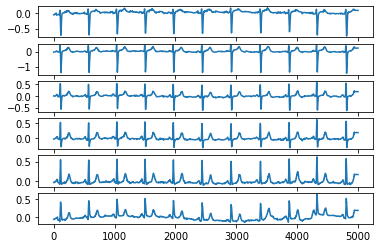

In [7]:
plot_ecgs(model_input[0])

In [8]:
#preprocess the ecgs
import neurokit2 as nk
import scipy.signal
def preprocess_data(raw_data):
    def leads_preprocess(leads):
        pre_leads = []
        for i in range(leads.shape[0]):
            lead = leads[i]
            lead = nk.signal_filter(lead, sampling_rate=500, lowcut=0.5, highcut=35, order=5) # denoise by butterworth bandpass filter
            lead = scipy.signal.resample(lead, int(lead.shape[0]/500*120)) #downsample to 120Hz
            lead = (lead - np.mean(lead)) / np.std(lead) if np.std(lead)!=0 else np.zeros_like(lead) # Z-score normalization
            pre_leads.append(lead)
        pre_leads = np.array(pre_leads)
        return pre_leads
    
    raw_data = np.transpose(raw_data, [0,2,1])
    preprocessed_data = []
    for i in range(raw_data.shape[0]):
        ecgs = leads_preprocess(raw_data[i])
        preprocessed_data.append(ecgs)
    preprocessed_data = np.array(preprocessed_data, dtype = 'float32')
    preprocessed_data = np.transpose(preprocessed_data, [0,2,1])
    return preprocessed_data

(10, 1200, 6)


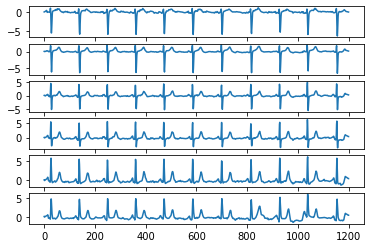

In [9]:
model_input = preprocess_data(model_input)
print(model_input.shape)
plot_ecgs(model_input[0])

In [10]:
#chest lead misplacement detection
# 0: Normal, 1:V1/V2, 2:V1/V3, 3:V2/V3, 4:V2/V4, 5:V3/V4, 6:V3/V5, 7:V4/V5, 8:V4/V6, 9: V5/V6
result = model.predict(model_input)
result = np.argmax(result, axis=-1)
print(result) # all normal

[0 0 0 0 0 0 0 0 0 0]


(10, 12, 5000)
(10, 1200, 6)


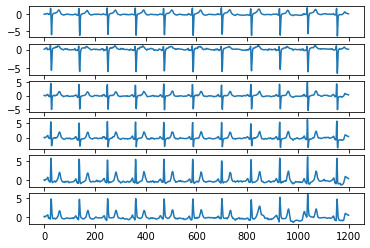

In [11]:
#simulate chest lead misplacement
def interchange_transform(mode,normal_leads):
    transformed_leads = np.copy(normal_leads)
    if mode == 1:
        transformed_leads[6]=normal_leads[7]
        transformed_leads[7]=normal_leads[6]
    elif mode == 2:
        transformed_leads[6]=normal_leads[8]
        transformed_leads[8]=normal_leads[6]
    elif mode == 3:
        transformed_leads[7]=normal_leads[8]
        transformed_leads[8]=normal_leads[7]
    elif mode == 4:
        transformed_leads[7]=normal_leads[9]
        transformed_leads[9]=normal_leads[7]
    elif mode == 5:
        transformed_leads[8]=normal_leads[9]
        transformed_leads[9]=normal_leads[8]
    elif mode == 6:
        transformed_leads[8]=normal_leads[10]
        transformed_leads[10]=normal_leads[8]
    elif mode == 7:
        transformed_leads[9]=normal_leads[10]
        transformed_leads[10]=normal_leads[9]
    elif mode == 8:
        transformed_leads[9]=normal_leads[11]
        transformed_leads[11]=normal_leads[9]
    elif mode == 9:
        transformed_leads[10]=normal_leads[11]
        transformed_leads[11]=normal_leads[10]
    else:
        pass
    return transformed_leads


chest_leads_misplacement_samples = np.copy(normal_sample)
chest_leads_misplacement_samples = np.transpose(chest_leads_misplacement_samples, [0,2,1])
print(chest_leads_misplacement_samples.shape)
mode = [1,2,3,4,5,6,7,8,9,0]
for i in range(normal_sample.shape[0]):
    chest_leads_misplacement_samples[i] = interchange_transform(mode[i],chest_leads_misplacement_samples[i])
chest_leads_misplacement_samples = np.transpose(chest_leads_misplacement_samples, [0,2,1])      
model_input = chest_leads_misplacement_samples[:,:,6:]
model_input = preprocess_data(model_input)
print(model_input.shape)
plot_ecgs(model_input[0])

In [12]:
# 0: Normal, 1:V1/V2, 2:V1/V3, 3:V2/V3, 4:V2/V4, 5:V3/V4, 6:V3/V5, 7:V4/V5, 8:V4/V6, 9: V5/V6
result = model.predict(model_input)
result = np.argmax(result, axis=-1)
print(result)

[1 2 3 4 5 6 7 8 9 0]
